### https://github.com/teto-ri/Kaggle-Project/blob/master/Predict_Future_Sales/predict-future-sales.ipynb  
Predict Future Sales PART 참고함 

### kaggle 집값 예측 문제

columns

- `house_id` - 주택 id변수
- `date` - 판매된 날자
- `location` - 주택 위치
- `type` - 주택 유형 ("2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE")
- `block` - 주택이 위치한 블록
- `street` - 주택이 위치한 거리
- `storey_range` - 주택이 위치한 층 범위
- `flat_model` - 주택의 모델(구조, 방 배치 등)
- `commence_date` - 주택이 판매에 올라온 날짜
- `price` - 판매 가격 (목표 변수)

다양한 변수를 사용하여 짒값을 예측한다
-> baseline code작성

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import time
import itertools

In [171]:
#데이터 불러오기
try:
    test = pd.read_csv('Data/test.csv', encoding='utf-8')
    train = pd.read_csv('Data/train.csv', encoding='utf-8')
except UnicodeDecodeError:
    #UTF-8로 실패한 경우 CP949로 재시도
    test = pd.read_csv('Data/test.csv', encoding='cp949')
    train = pd.read_csv('Data/train.csv', encoding='cp949')    

In [172]:
 train.head(5)

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,price
0,199577,2006-09,Raleigh,5 ROOM,107D,Agawan Court,07 TO 09,110.0,D,2003,313000.0
1,217021,2007-06,Fresno,3 ROOM,678,Cleo St,07 TO 09,64.0,N,1988,167000.0
2,308062,2010-09,Tucson,4 ROOM,5,E Pleasant View Way,10 TO 12,92.0,K,1976,430000.0
3,212465,2007-04,Austin,4 ROOM,326,Park Hollow Ln,10 TO 12,92.0,K,1977,303800.0
4,60654,2001-10,Honolulu,4 ROOM,794,Ala Puawa Place,04 TO 06,102.0,G,1998,212000.0


In [173]:
test.head()

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date
0,2,2000-01,Austin,3 ROOM,174,Governors Row,04 TO 06,61.0,D,1986
1,5,2000-01,Austin,3 ROOM,218,Stonleigh Pl,07 TO 09,67.0,K,1976
2,22,2000-01,Austin,3 ROOM,443,Palisades Point Cove,07 TO 09,67.0,K,1979
3,23,2000-01,Austin,3 ROOM,443,Palisades Point Cove,07 TO 09,67.0,K,1979
4,28,2000-01,Austin,3 ROOM,435,Palisades Point Cove,04 TO 06,67.0,K,1979


In [174]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271721 entries, 0 to 271720
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   house_id       271721 non-null  int64  
 1   date           271721 non-null  object 
 2   location       271721 non-null  object 
 3   type           271721 non-null  object 
 4   block          271721 non-null  object 
 5   street         271721 non-null  object 
 6   storey_range   271721 non-null  object 
 7   area_sqm       271721 non-null  float64
 8   flat_model     271721 non-null  object 
 9   commence_date  271721 non-null  int64  
 10  price          271721 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 22.8+ MB


In [175]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67930 entries, 0 to 67929
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   house_id       67930 non-null  int64  
 1   date           67930 non-null  object 
 2   location       67930 non-null  object 
 3   type           67930 non-null  object 
 4   block          67930 non-null  object 
 5   street         67930 non-null  object 
 6   storey_range   67930 non-null  object 
 7   area_sqm       67930 non-null  float64
 8   flat_model     67930 non-null  object 
 9   commence_date  67930 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 5.2+ MB


In [176]:
train.isnull().sum()

house_id         0
date             0
location         0
type             0
block            0
street           0
storey_range     0
area_sqm         0
flat_model       0
commence_date    0
price            0
dtype: int64

In [177]:
test.isnull().sum()

house_id         0
date             0
location         0
type             0
block            0
street           0
storey_range     0
area_sqm         0
flat_model       0
commence_date    0
dtype: int64

In [178]:
train.duplicated().sum()
#중복 데이터 확인

0

In [179]:
train[train.duplicated()==True]

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,price


In [180]:
train.drop_duplicates(inplace=True)

In [181]:
train.duplicated().sum()

0

<Axes: >

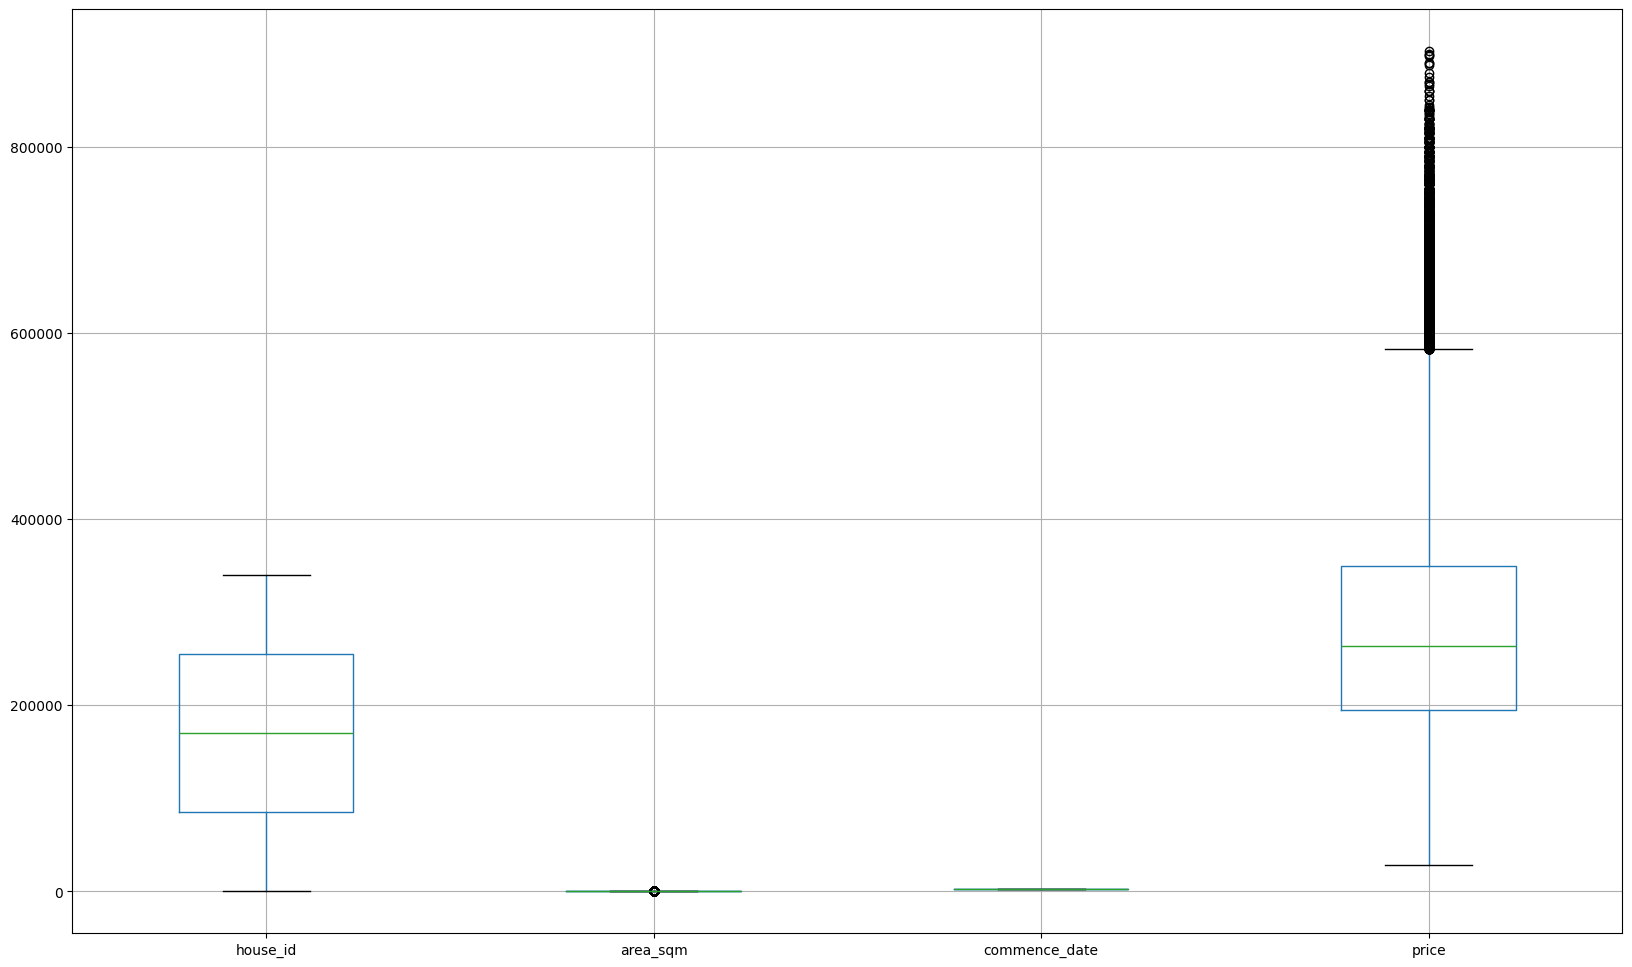

In [182]:
plt.figure(figsize=(20,12))
train.boxplot()

<Axes: xlabel='price'>

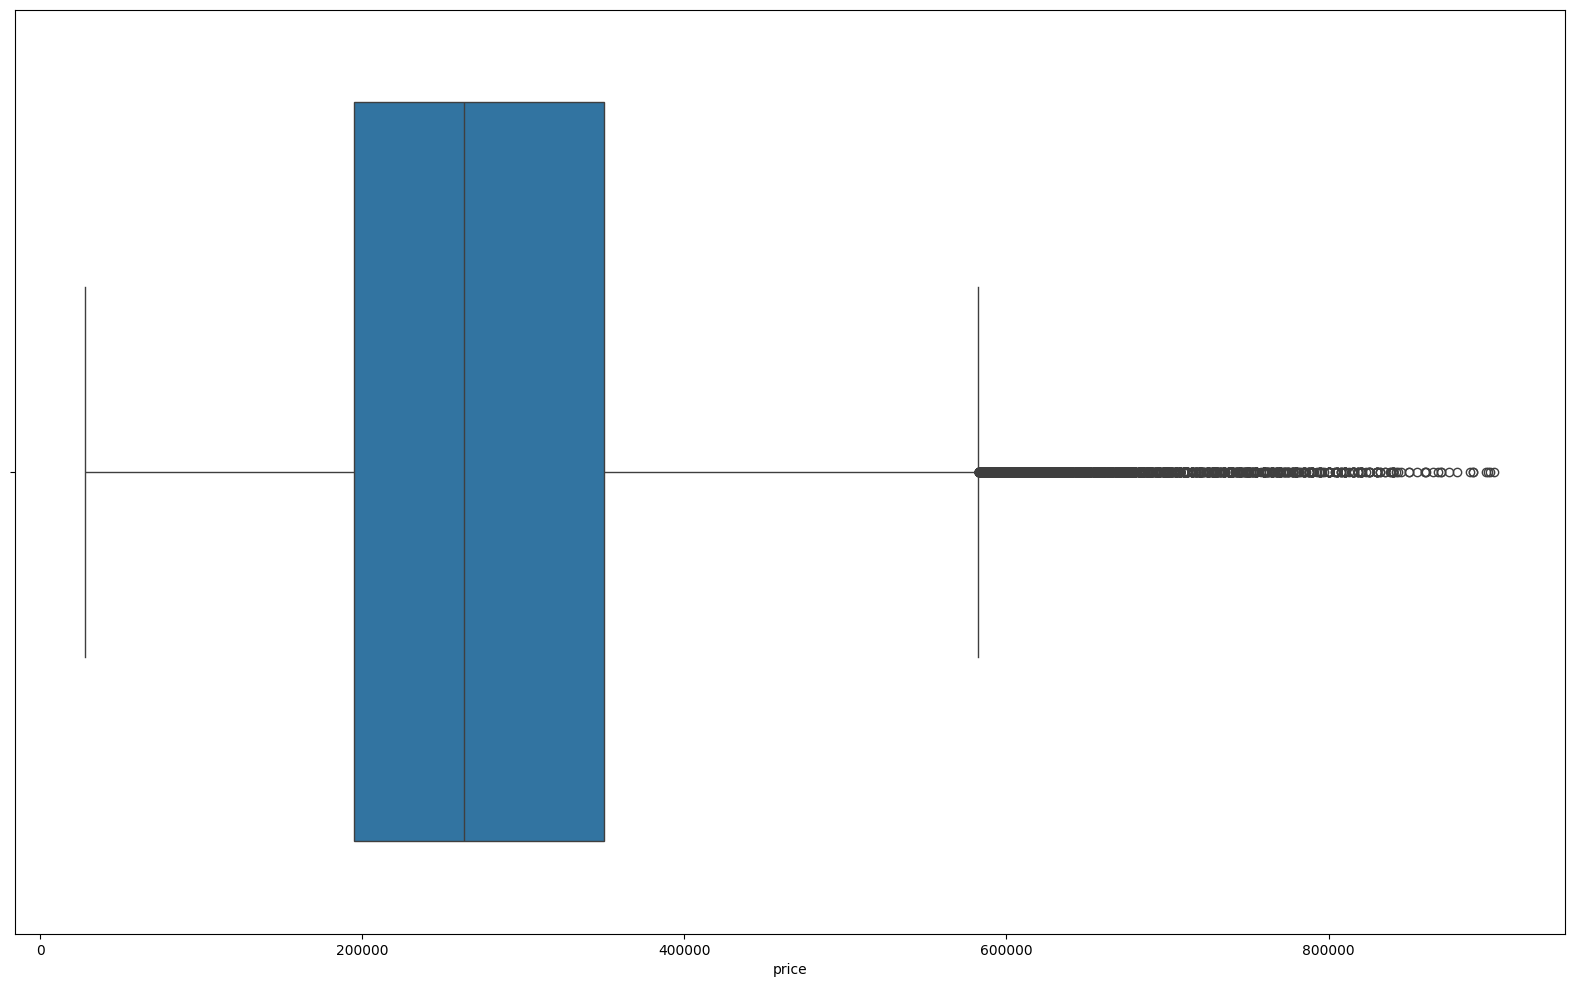

In [183]:
plt.figure(figsize=(20,12))
sns.boxplot(x='price', data = train)

<Axes: xlabel='date'>

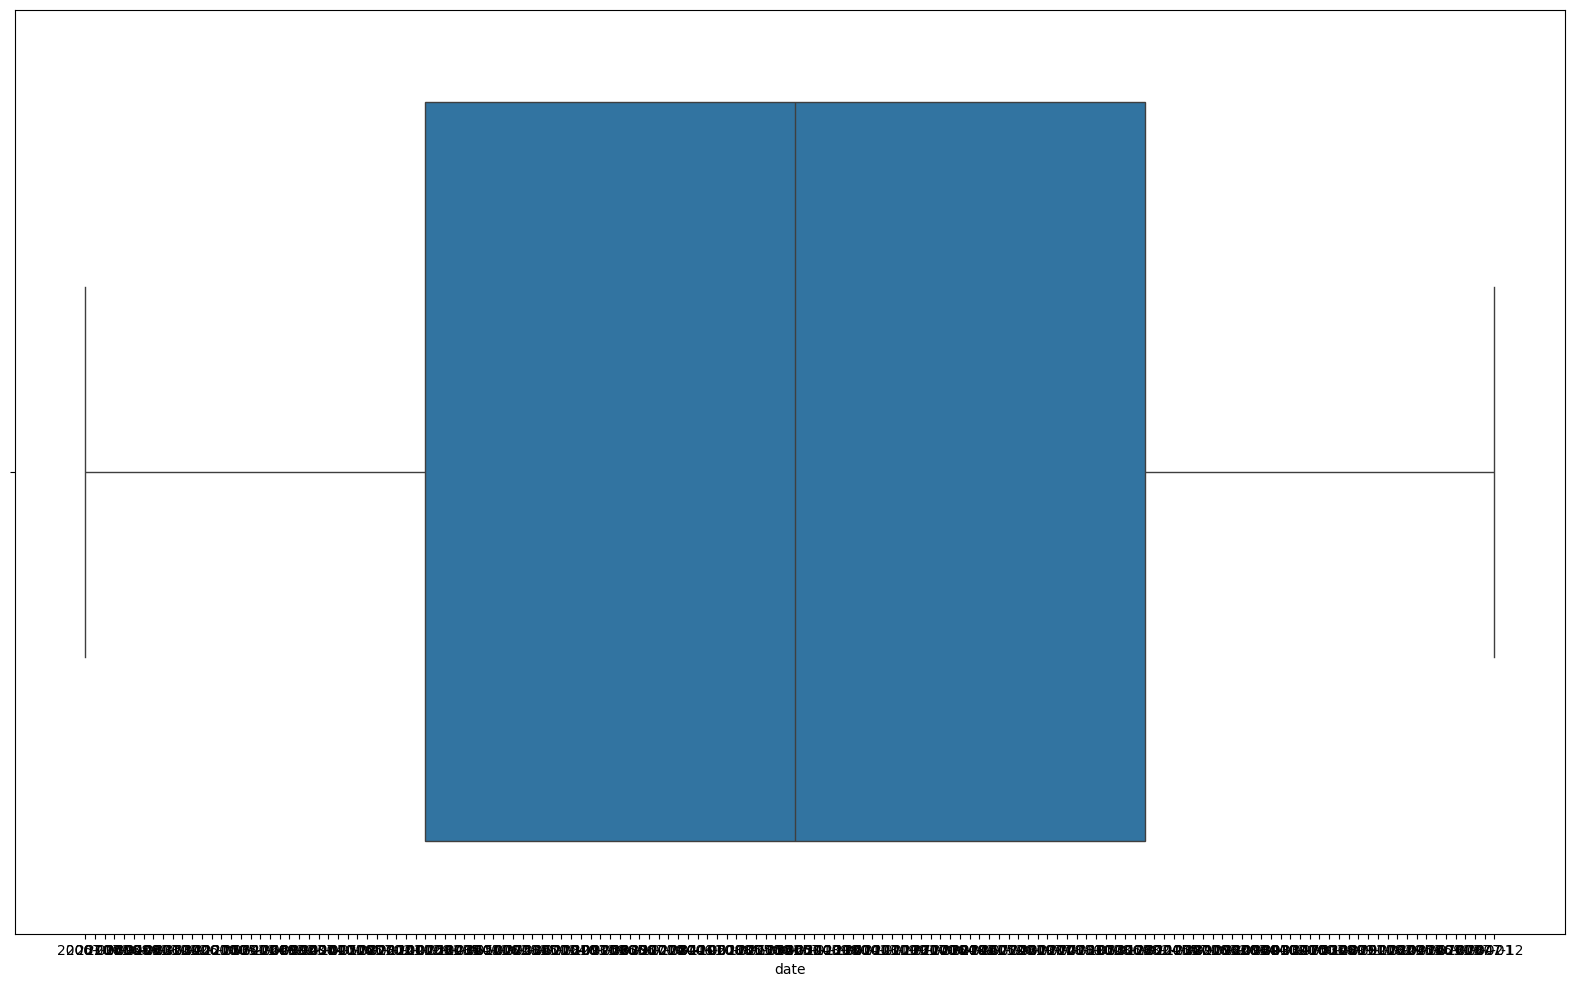

In [184]:
#주택이 판매된 날짜
plt.figure(figsize=(20,12))
sns.boxplot(x='date', data = train)

<Axes: xlabel='commence_date'>

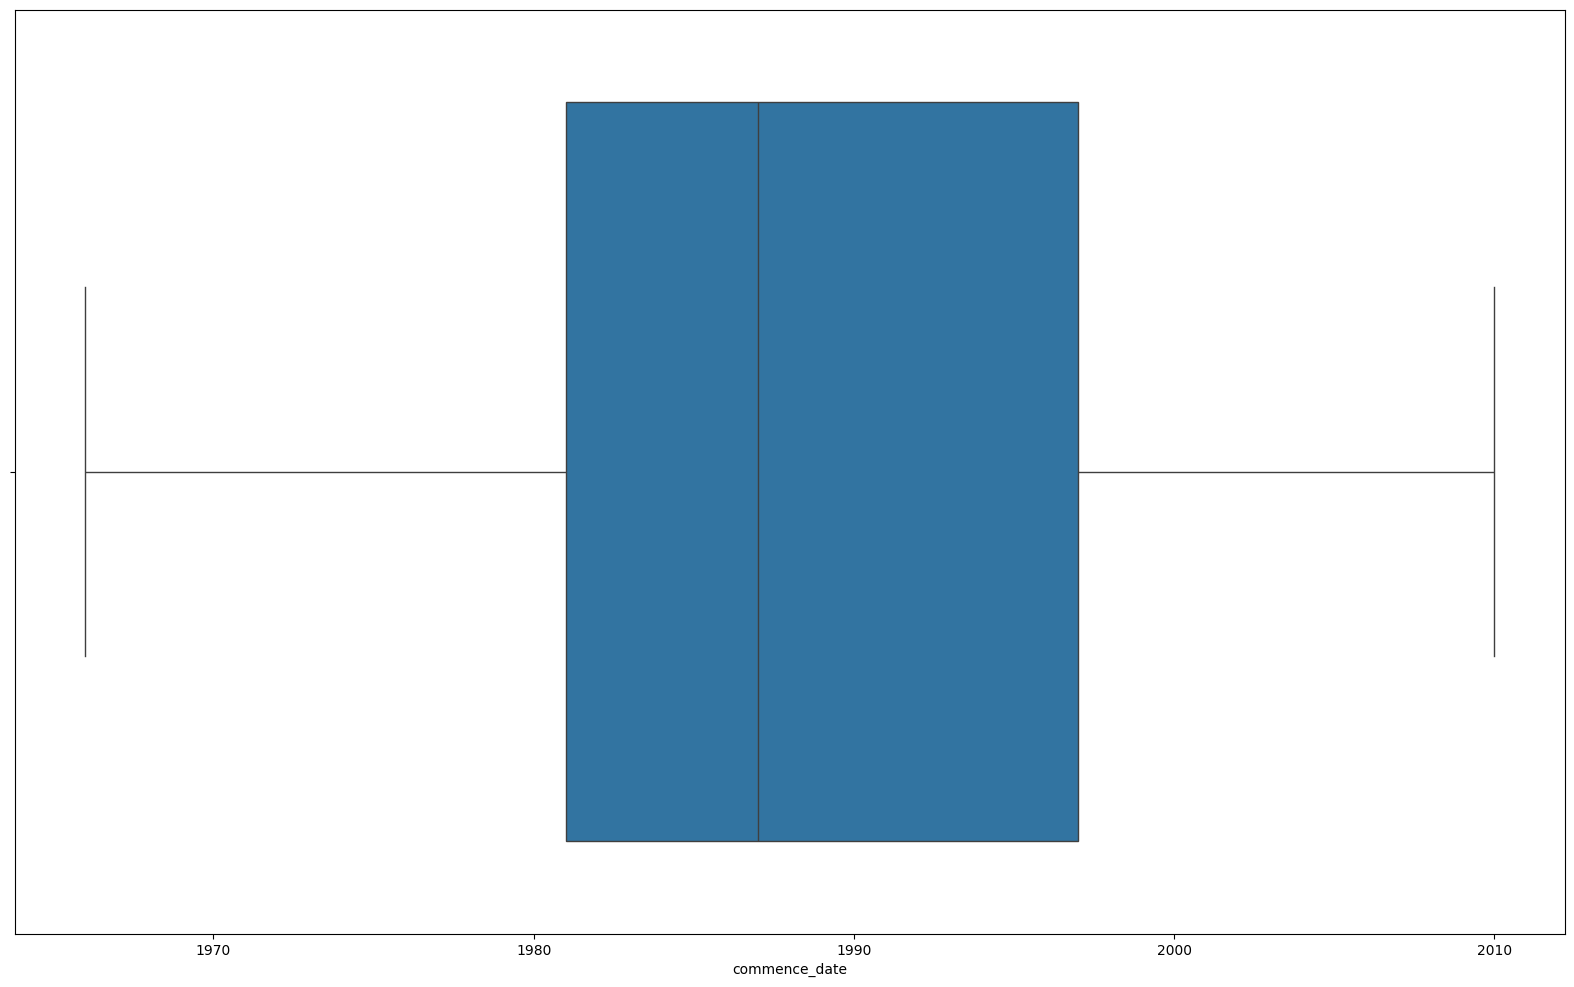

In [185]:
#주택이 판매에 올라온 날짜
plt.figure(figsize=(20,12))
sns.boxplot(x='commence_date', data = train)

In [186]:
train.shape

(271721, 11)

In [187]:
test.shape

(67930, 10)

In [188]:
train.describe()

,house_id,area_sqm,commence_date,price
count,271721.000000,271721.000000,271721.000000,271721.000000
mean,169785.994870,96.544832,1987.982942,281197.589537
std,98022.533902,25.587877,9.125141,112160.993184
min,1.000000,28.000000,1966.000000,28000.000000
25%,85021.000000,73.000000,1981.000000,195000.000000
50%,169739.000000,99.000000,1987.000000,263000.000000
75%,254609.000000,115.000000,1997.000000,350000.000000
max,339651.000000,280.000000,2010.000000,903000.000000


### Data Preprocessing

In [189]:
#address 컬럼을 생성 후, location 과 street 컬럼을 합쳐 ' ' 으로 구분되도록 함.

train['address'] = train['location'] + ' ' + train['street']

train

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,price,address
0,199577,2006-09,Raleigh,5 ROOM,107D,Agawan Court,07 TO 09,110.0,D,2003,313000.0,Raleigh Agawan Court
1,217021,2007-06,Fresno,3 ROOM,678,Cleo St,07 TO 09,64.0,N,1988,167000.0,Fresno Cleo St
2,308062,2010-09,Tucson,4 ROOM,5,E Pleasant View Way,10 TO 12,92.0,K,1976,430000.0,Tucson E Pleasant View Way
3,212465,2007-04,Austin,4 ROOM,326,Park Hollow Ln,10 TO 12,92.0,K,1977,303800.0,Austin Park Hollow Ln
4,60654,2001-10,Honolulu,4 ROOM,794,Ala Puawa Place,04 TO 06,102.0,G,1998,212000.0,Honolulu Ala Puawa Place
...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,2003-01,Omaha,4 ROOM,483,Sandra Ln,04 TO 06,103.0,G,1989,232000.0,Omaha Sandra Ln
271717,28297,2000-11,Omaha,5 ROOM,615,Atkin Rd,10 TO 12,134.0,G,1996,428000.0,Omaha Atkin Rd
271718,321995,2011-04,Boston,5 ROOM,390,Kempton Street,13 TO 15,118.0,D,2004,548888.0,Boston Kempton Street
271719,308162,2010-09,Fresno,4 ROOM,968,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0,Fresno Magnolia Dale Dr


In [190]:
#새로 생성 된 address 컬럼의 내용을 임의로 바꿔서 맛있게 먹어보자
train.loc[train['address'] == 'Omaha Sandra Ln', 'address'] = 'Ohama Daegari GMT'

In [191]:
train['address'].value_counts()

address
Riverside Laredo Rd            4569
Austin Palisades Point Cove    3903
Seatle 50th Avenue NE          3608
Austin Park Hollow Ln          3383
Fresno Cleo St                 2735
                               ... 
Seatle Holly Ter S                3
Tucson Wade Pl                    3
Atlanta Lullwater Park Way        1
Raleigh Marvin Place              1
Minneapolis Dakota Rd             1
Name: count, Length: 523, dtype: int64

In [192]:
train

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,price,address
0,199577,2006-09,Raleigh,5 ROOM,107D,Agawan Court,07 TO 09,110.0,D,2003,313000.0,Raleigh Agawan Court
1,217021,2007-06,Fresno,3 ROOM,678,Cleo St,07 TO 09,64.0,N,1988,167000.0,Fresno Cleo St
2,308062,2010-09,Tucson,4 ROOM,5,E Pleasant View Way,10 TO 12,92.0,K,1976,430000.0,Tucson E Pleasant View Way
3,212465,2007-04,Austin,4 ROOM,326,Park Hollow Ln,10 TO 12,92.0,K,1977,303800.0,Austin Park Hollow Ln
4,60654,2001-10,Honolulu,4 ROOM,794,Ala Puawa Place,04 TO 06,102.0,G,1998,212000.0,Honolulu Ala Puawa Place
...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,2003-01,Omaha,4 ROOM,483,Sandra Ln,04 TO 06,103.0,G,1989,232000.0,Ohama Daegari GMT
271717,28297,2000-11,Omaha,5 ROOM,615,Atkin Rd,10 TO 12,134.0,G,1996,428000.0,Omaha Atkin Rd
271718,321995,2011-04,Boston,5 ROOM,390,Kempton Street,13 TO 15,118.0,D,2004,548888.0,Boston Kempton Street
271719,308162,2010-09,Fresno,4 ROOM,968,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0,Fresno Magnolia Dale Dr


In [193]:
#라벨 인코딩: 모델이 이해하기 쉽도록 범주형 데이터를 숫자로 분류하여 줌
train['address_code'] = LabelEncoder().fit_transform(train['address'])

categorial_features = ['type', 'block', 'storey_range', 'flat_model']
numerical_features = ['area_sqm']

le = LabelEncoder()
for i in categorial_features:
    train[i] = le.fit_transform(train[i])

scaler = MinMaxScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])

In [194]:
#라벨 인코딩 후 Object(문자열) 컬럼들을 제거 함.
train = train.drop(['address'], axis = 1)
train = train.drop(['location'], axis = 1)
train = train.drop(['street'], axis = 1)

In [195]:
tmp = {}
tmp['date'] = pd.to_datetime(train['date'])
train['year'] = tmp['date'].dt.year
train['month'] = tmp['date'].dt.month
train.drop('date', axis = 1, inplace = True)

In [196]:
train

,house_id,type,block,storey_range,area_sqm,flat_model,commence_date,price,address_code,year,month
0,199577,4,34,2,0.325397,3,2003,313000.0,346,2006,9
1,217021,2,1445,2,0.142857,13,1988,167000.0,131,2007,6
2,308062,3,1092,3,0.253968,10,1976,430000.0,458,2010,9
3,212465,3,742,3,0.253968,10,1977,303800.0,62,2007,4
4,60654,3,1662,1,0.293651,6,1998,212000.0,153,2001,10
...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,3,1004,1,0.297619,6,1989,232000.0,300,2003,1
271717,28297,4,1257,3,0.420635,6,1996,428000.0,301,2000,11
271718,321995,4,853,4,0.357143,3,2004,548888.0,78,2011,4
271719,308162,3,1936,4,0.246032,8,1999,360000.0,136,2010,9


### Saving data and Cleaning ram

In [197]:
import os
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4

In [198]:
train.to_pickle('Data/data.pkl')
gc.collect();

In [199]:
data = pd.read_pickle('Data/data.pkl')

In [200]:
data

,house_id,type,block,storey_range,area_sqm,flat_model,commence_date,price,address_code,year,month
0,199577,4,34,2,0.325397,3,2003,313000.0,346,2006,9
1,217021,2,1445,2,0.142857,13,1988,167000.0,131,2007,6
2,308062,3,1092,3,0.253968,10,1976,430000.0,458,2010,9
3,212465,3,742,3,0.253968,10,1977,303800.0,62,2007,4
4,60654,3,1662,1,0.293651,6,1998,212000.0,153,2001,10
...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,3,1004,1,0.297619,6,1989,232000.0,300,2003,1
271717,28297,4,1257,3,0.420635,6,1996,428000.0,301,2000,11
271718,321995,4,853,4,0.357143,3,2004,548888.0,78,2011,4
271719,308162,3,1936,4,0.246032,8,1999,360000.0,136,2010,9


In [201]:
X = train.drop('price', axis = 1)
y = train['price']

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [203]:
ts = time.time()

model = XGBRegressor(
    max_depth = 10,
    n_estimators=1000,
    min_child_weight=0.5,
    colsample_bytree=0.8,
    subsample=0.8,
    era=0.1,
    seed=77
)

model.fit(
    X_train,
    y_train,
    eval_metric="rmse",
    eval_set = [(X_train, y_train), (X_test, y_test)],
    verbose = True,
    early_stopping_rounds=20
)

time.time() - ts

[0]	validation_0-rmse:82591.76254	validation_1-rmse:82413.68515
[1]	validation_0-rmse:63795.44175	validation_1-rmse:63796.18775
[2]	validation_0-rmse:50987.72005	validation_1-rmse:51102.95572
[3]	validation_0-rmse:40750.02351	validation_1-rmse:41070.44927
[4]	validation_0-rmse:34343.35118	validation_1-rmse:34885.62968
[5]	validation_0-rmse:30135.93449	validation_1-rmse:30890.76233


c:\Users\cchok\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\cchok\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\cchok\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:03:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "era" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:27099.72510	validation_1-rmse:28014.27775
[7]	validation_0-rmse:25148.78172	validation_1-rmse:26274.24589
[8]	validation_0-rmse:24142.75631	validation_1-rmse:25445.35417
[9]	validation_0-rmse:22980.75444	validation_1-rmse:24386.04546
[10]	validation_0-rmse:21839.93275	validation_1-rmse:23376.84873
[11]	validation_0-rmse:20238.46573	validation_1-rmse:21881.46881
[12]	validation_0-rmse:19816.61660	validation_1-rmse:21558.49064
[13]	validation_0-rmse:18913.38011	validation_1-rmse:20709.39918
[14]	validation_0-rmse:18598.00700	validation_1-rmse:20457.19442
[15]	validation_0-rmse:18274.59154	validation_1-rmse:20190.83004
[16]	validation_0-rmse:18048.25220	validation_1-rmse:20023.81677
[17]	validation_0-rmse:17751.64851	validation_1-rmse:19805.26925
[18]	validation_0-rmse:17532.23066	validation_1-rmse:19642.65316
[19]	validation_0-rmse:17334.94571	validation_1-rmse:19498.00975
[20]	validation_0-rmse:17238.64114	validation_1-rmse:19461.84446
[21]	validation_0-rmse:17119.

2.977047920227051

In [204]:
X_test.shape

(54345, 10)

In [205]:
y_pred_train = model.predict(X_train).clip(0, 20)
y_pred_test = model.predict(X_test).clip(0, 20)

sub = pd.DataFrame({
    "house_id" : X_test.index,
    "price":y_pred_test
})

sub.to_csv('xgb_sub.csv', index = False)

pickle.dump(y_pred_train, open('Data/xgb_train.pickle','wb'))
pickle.dump(y_pred_test, open('Data/xgb_train.pickle','wb'))

수정 사항
데이터 준비 및 분할:

train_test_split을 사용하여 X와 y 데이터를 분리합니다.
모델 예측:

clip 메서드를 사용하여 예측값을 0과 20 사이로 제한합니다.
결과 저장:

house_id를 X_test의 인덱스에서 가져옵니다.
y_pred_test 예측값을 사용하여 sub 데이터프레임을 생성합니다.
sub 데이터프레임을 CSV 파일로 저장합니다.
이제 데이터프레임 생성 시 배열 길이 불일치 문제를 해결할 수 있습니다. house_id는 X_test의 인덱스를 사용하여 동일한 길이로 설정되었으며, y_pred_test와 house_id의 길이가 일치하게 됩니다.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

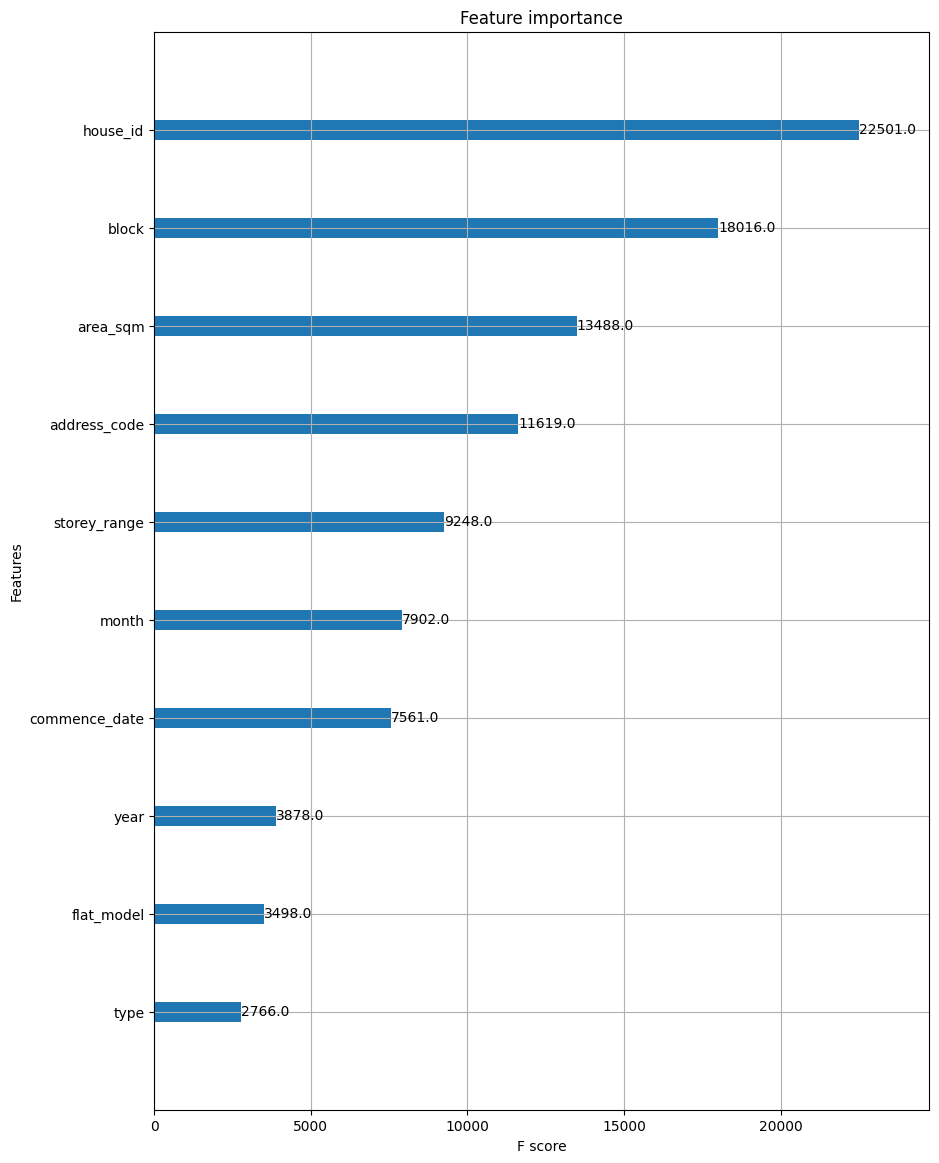

In [207]:
from xgboost import plot_importance

def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))